# Map orientation

Below we discuss various things relating to the orientation of the surface maps in `starry`.

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import starry

starry.config.lazy = False

## Inclination and obliquity of `Map` instances

Let's construct a 20th-degree map and load the continental map of the Earth.

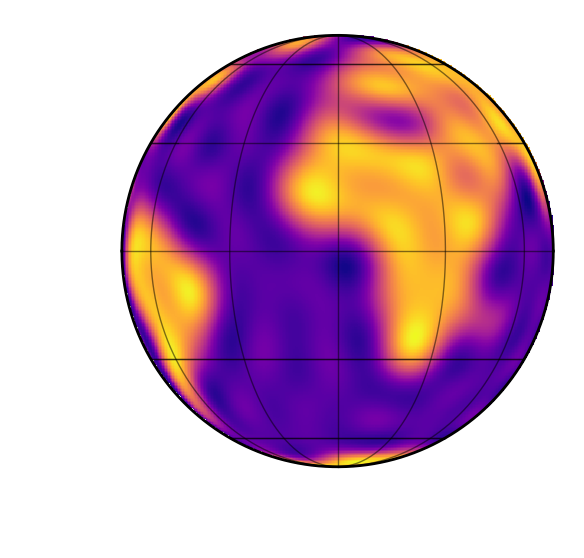

In [16]:
ydeg = 20
earth_map = starry.Map(ydeg=ydeg, quiet=True)
earth_map.load("earth")
earth_map.show()

Now, just as an example, let's give the Earth an obliquity of 23.5 degrees and an inclination of 60 degrees. 
In the previous version of `starry`, we did this by setting the `axis` property, but now we can directly set the inclination `inc` and obliquity `obl`.

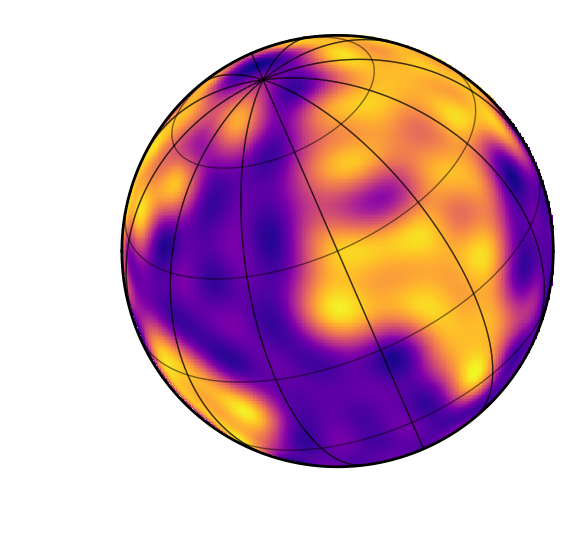

In [4]:
earth_map.obl = 23.5
earth_map.inc = 60.0
earth_map.show()

Several comments about what we just did:

#### 1. We specified the angles in degrees

That's because the default angular unit for maps is

In [5]:
earth_map.angle_unit

Unit("deg")

(i.e., degrees). We could change that to radians by specifying
```python
from astropy import units as u
earth_map.angle_unit = u.radian
```

#### 2. Definition of the angles
In ``starry`` we define the obliquity to be the angle of rotation on the sky, measured counter-clockwise from north. The inclination is the angle between the axis of rotation and the line of sight (the usual definition for exoplanets).

#### 3. The inclination and obliquity specify the vantage point of the observer

In the previous version of `starry`, changing the axis of rotation of the map changed the actual location of the rotational poles on the surface. In other wor., the axis of rotation was an intrinsic property of the map, specifying the location of the poles in the observer's reference frame. *That has changed in version 1.0.0*. The axis of rotation (determined by `inc` and `obl`) is now a property of the *observer*; changing these values change the angle at which the map is seen by the observer. The location of the poles on the surface of the body therefore remain fixed.

This change is due to the fact that as of `starry` 1.0.0, the spherical harmonic coefficients are defined relative to the rotational axis of the map in a static, observer-independent frame. Changing the map inclination or obliquity merely changes the vantage point of the observer, not the spherical harmonic coefficients.

#### 4. The `show` method

Finally, note that the `show()` method can also animate the map as it rotates:

In [6]:
theta = np.linspace(0, 360, 50)
earth_map.show(theta=theta)

It can also plot an equi-rectangular (latitude-longitude) view of the map:

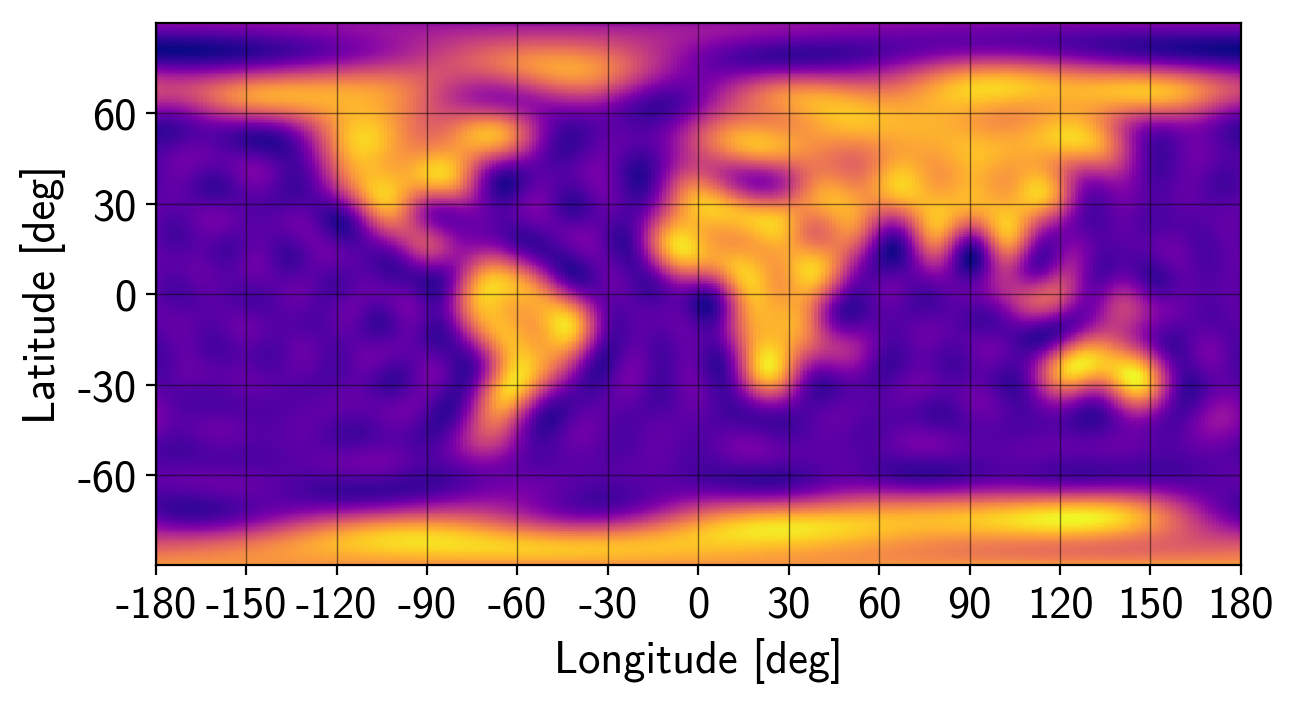

In [7]:
earth_map.show(projection="rect")

## Inclination and obliquity of `Secondary` instances

Understanding the inclination and obliquity of a standalone `Map` instance is straightforward. But things can get a little tricky when we're modeling the surface map of a body in a Keplerian orbit, since we have the orbital inclination ($i$) and obliquity ($\Omega$, usually called the longitude of ascending node) to worry about as well.

The thing to remember is this: the `inc` and `obl` attributes of the *map* tell you everything you need to know about the orientation of the surface map on the sky. Changing the inclination and longitude of ascending node of the *body* only affects the orientation orbit, not the orientation of the map.

Below, we instantiate a Keplerian system using the Earth map (inclination $60^\circ$ and obliquity $23.5^\circ$) defined above. We give the *planet* an inclination of $45^\circ$ and a longitude of ascending node of $10^\circ$. However, as we will see, when we compute the system flux, we get the same light curve as before: the light curve of the Earth rotating at inclination $60^\circ$ and obliquity $23.5^\circ$.

Compiling `flux`... Done.
/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
Compiling `flux`... Done.


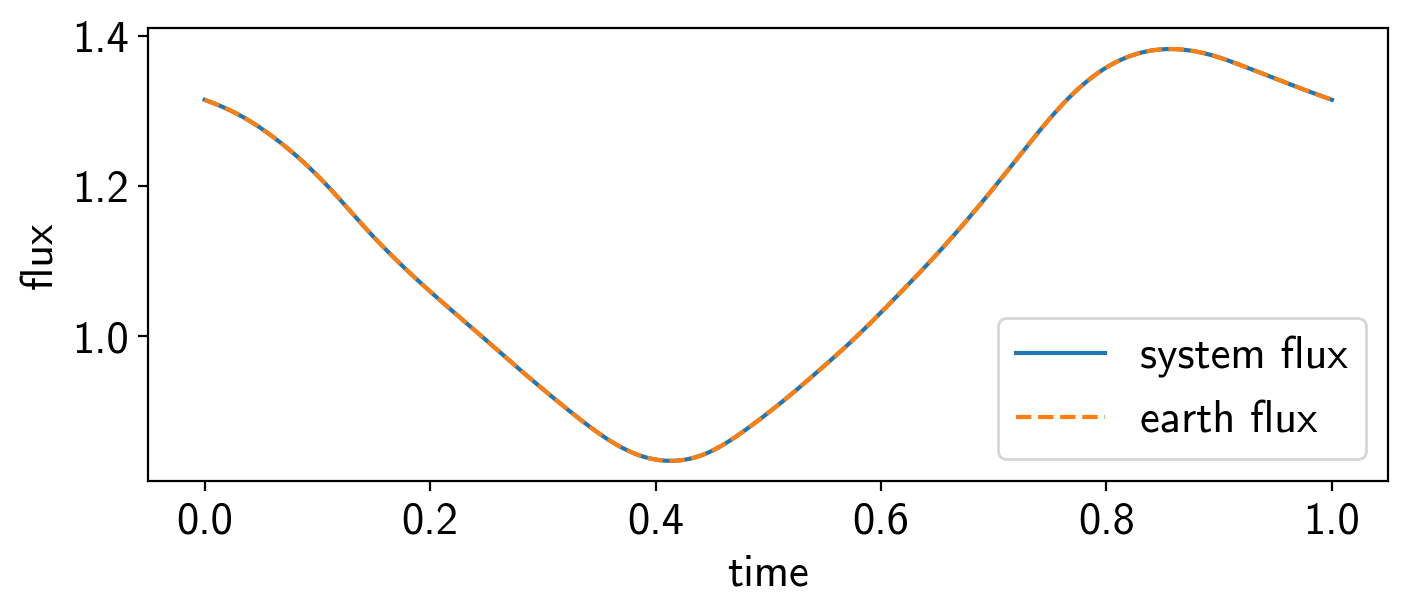

In [8]:
# Define the Earth-Sun system
sun = starry.Primary(starry.Map(L=0.0))
earth = starry.Secondary(earth_map, porb=1.0, r=0.01, inc=45.0, Omega=10.0)
sys = starry.System(sun, earth)
t = np.linspace(0, 1, 1000)

# Plot the system light curve
fig = plt.figure(figsize=(8, 3))
plt.plot(t, sys.flux(t), label="system flux")

# Plot just the Earth's light curve
plt.plot(t, earth_map.flux(theta=360.0 * t), "--", label="earth flux")

# Labels
plt.xlabel("time")
plt.ylabel("flux")
plt.legend();

To recap, let's say we define the following `Secondary` instance:

```python
planet = starry.Secondary(
    starry.Map(
        inc=inc_map, 
        obl=obl_map
    ), 
    inc=inc_orb, 
    Omega=Omega_orb
)
```

There are four angles to be aware of: two associated with the `Map` instance (`inc_map` and `obl_map`), and two associated with the `Secondary` instance (`inc_orb` and `Omega_orb`). The first two define the orientation of the surface map on the sky, and the last two define the orientation of the orbit on the sky. Unfortunately, both the map and orbital inclinations have the same name, but one is a keyword argument to ``Map`` and one is a keyword argument to ``Secondary``. Another, perhaps less confusing, way to define this system is as follows:

```python
planet = starry.Secondary(starry.Map())
planet.map.inc = inc_map
planet.map.obl = obl_map
planet.inc = inc_orb
planet.Omega = Omega_orb
```

While this convention is nice because it decouples the orbit from the rotation of the planet, it is often the case that the orbital plane and the equatorial plane are the same (such as for a tidally locked planet), in which case the two inclinations and the two obliquities are the same. In this case, we can explicitly set them equal to each other:

```python
planet = starry.Secondary(starry.Map())
planet.inc = planet.map.inc
planet.Omega = planet.map.obl
```

## The rotational phase of `Secondary` instances

Finally, we must also be careful about the rotational phase `theta` of the map when using `Secondary` instances. All `Secondary` instances have a `theta0` parameter, which specifies the rotational phase of the map at time `t0` (also a property of all `Secondary` instances). By default, `theta0 = 0`, so when `t = t0` (whose default value is also zero), the line of sight vector intersects the prime meridian (longitude zero) of the map.

The parameter `t0` also specifies the time of transit (or inferior conjunction, if the body does not transit), so if `theta0` is kept at its default value of zero, the map coefficients describe what the body looks like  if it were viewed by an observer seeing the system edge on while the secondary body is transiting. **Note that this is different from the convention adopted in the beta (0.3.0) version.**

Let's look at an example. Below we instantiate a simple tidally-locked star-planet system.

In [9]:
star = starry.Primary(starry.Map())
planet = starry.Secondary(starry.Map(ydeg=1, L=0.01), porb=1.0, prot=1.0, r=0.1)
sys = starry.System(star, planet)
t = np.linspace(0, 1, 10000)

We will give the planet a simple dipole map:

In [10]:
planet.map[1, 0] = 0.5

In the static frame, this corresponds to the following surface map:

Compiling `render`... Done.


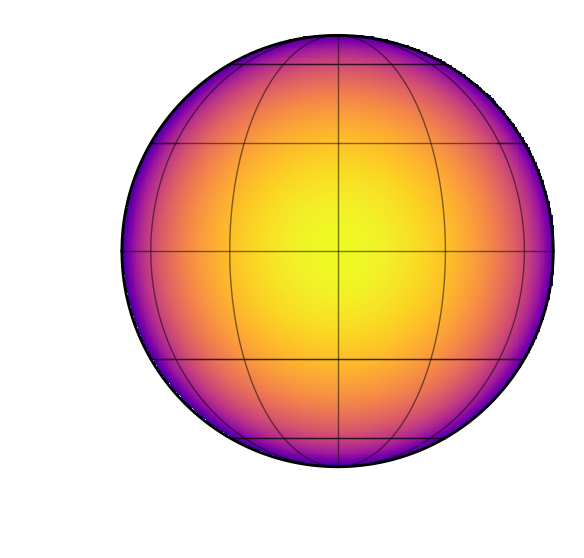

In [11]:
planet.map.show()

By default, the inclination of the orbit (and of the map) is $90^\circ$, and `t0`, `theta0`, and the eccentricity are all zero. Here's what the system light curve looks like, along with the orientation of the map at several points in time:

In [12]:
def visualize(sys):
    fig = plt.figure(figsize=(8, 3))
    nrow, ncol = 4, 9
    aximg = [plt.subplot2grid((nrow, ncol), (0, i)) for i in range(ncol)]
    ax = plt.subplot2grid((nrow, ncol), (1, 0), colspan=ncol, rowspan=nrow - 1)
    ax.plot(t, sys.flux(t))
    theta = np.linspace(0, 360, ncol) + sys.secondaries[0].theta0
    for i in range(ncol):
        aximg[i].imshow(sys.secondaries[0].map.render(res=100, theta=theta[i]), origin="lower", cmap="plasma")
        aximg[i].axis("off")

Compiling `flux`... Done.
/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


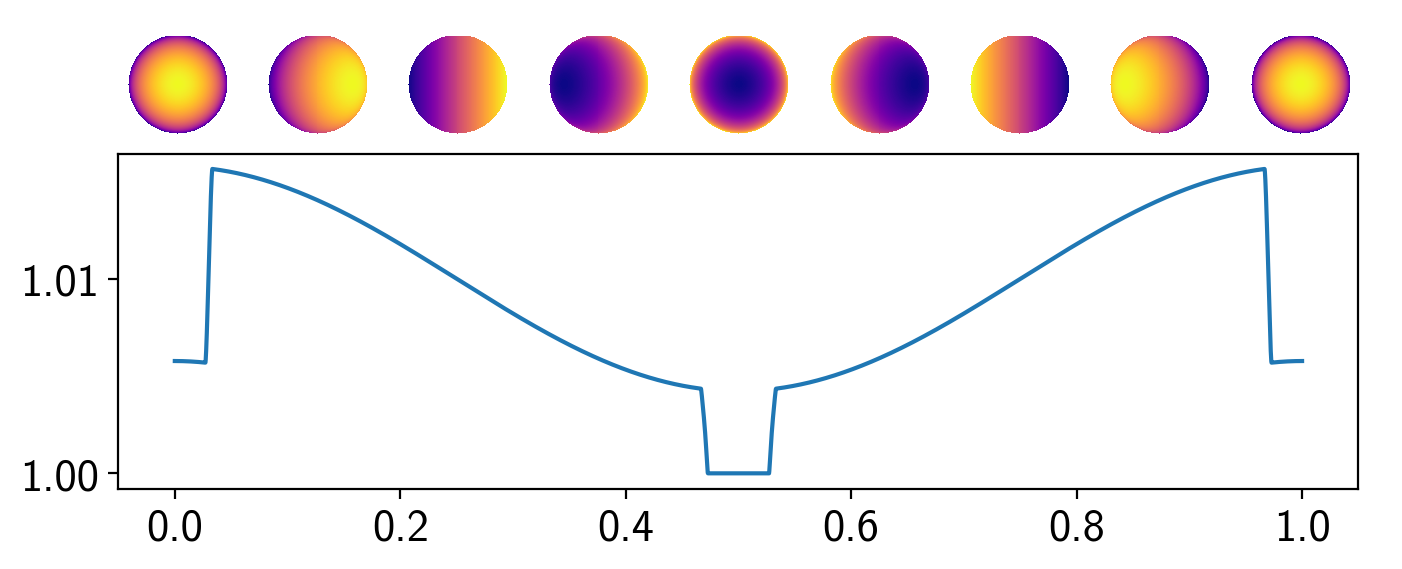

In [13]:
visualize(sys)

The transit occurs at $t = 0$ (and $t = 1$) and the secondary eclipse occurs at $t = 0.5$. As we mentioned above, at $t = t_0$ the map is at its initial phase. Since `t0` corresponds to a transiting configuration, the bright side of the planet is facing *away* from the star and toward the observer at this time. This is *probably* undesirable, since normally we'd expect the bright side of the planet to face the star.

The easiest way around this is to add a $180^\circ$ phase offset via the `theta0` parameter:

In [14]:
planet.map[1, 0] = 0.5
planet.theta0 = 180

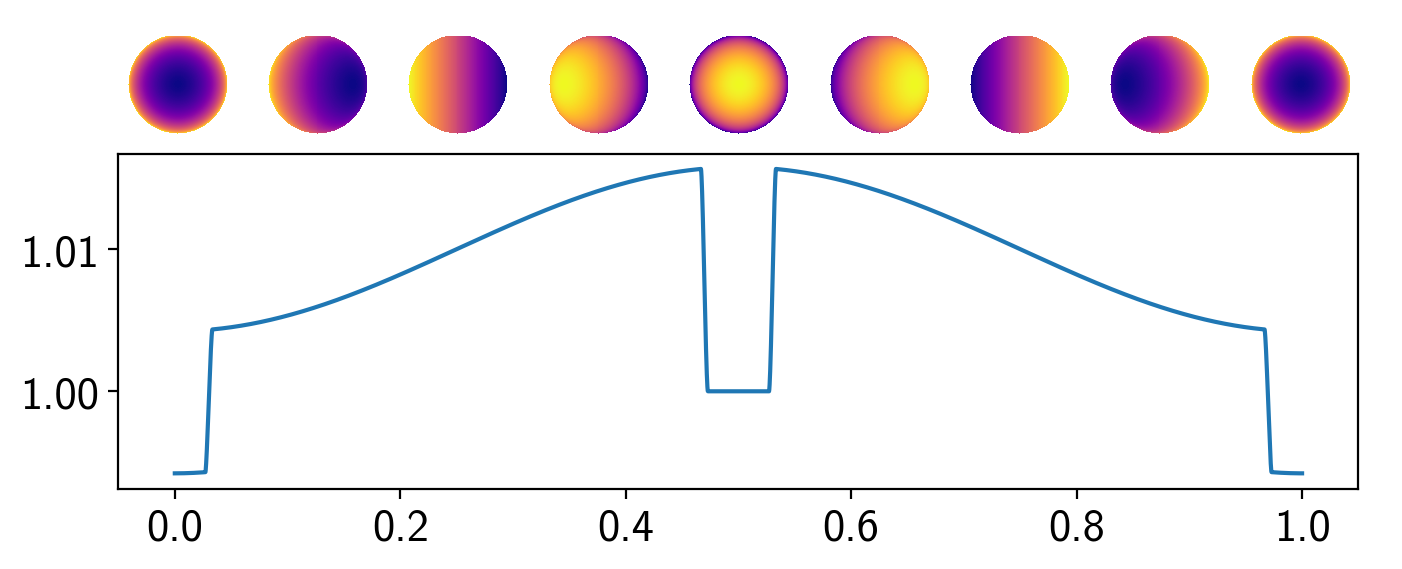

In [15]:
visualize(sys)